In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
import swifter

bag_of_words_df=pd.read_csv('bag_of_words.csv')
comments_df=pd.read_csv('cleaned_data.csv')

bag_of_words_df=bag_of_words_df.join(comments_df['editorsSelection'].replace({True:1,False:0}))

bag_of_words_df.columns



/tmp/ipykernel_25594/1425528725.py:16: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_df=pd.read_csv('cleaned_data.csv')


Index(['actual', 'administr', 'agre', 'allow', 'alreadi', 'also', 'alway',
       'america', 'american', 'anoth',
       ...
       'without', 'wonder', 'word', 'work', 'world', 'would', 'ye', 'year',
       'yet', 'editorsSelection'],
      dtype='object', length=209)

In [35]:
import time
from scipy.spatial.distance import euclidean
def initialize_centroids(df, k):
    """
    Function to initialize random centroids from dataset.
    Input: 
        - df: pandas dataframe with the data
        - k: integer number of clusters
    Output: 
        - temp_df: pandas dataframe with the centroids as columns and index as label
    """
    centroids = []
    for i in range(k):
        centroids.append(df.apply(lambda x: float(x.sample()))) # Take a random sample from each column to create a centroid
    centroids = pd.concat(centroids, axis=1)
    centroids.index.name = 'Label'

    return centroids


def assign_labels(df, centroids):
    """
    Function to calculate the closest centroid label for each row in a dataframe.
    Input: 
        - df: pandas dataframe with the data
        - centroids: pandas dataframe with the centroids as columns and index as label
    Output: 
        - distances.idxmin(axis=1): pandas series with the label of the closest centroid for each row in df
    """
    distances = centroids.swifter.apply(lambda x: np.sqrt(((df - x) ** 2).sum(axis=1))) # Calculate the Euclidean distance between each row in df and each centroid
    return distances.idxmin(axis=1) # Get the index of the minimum distance, which corresponds to the label of the closest centroid


def new_centroids(df_label, df1):
    """
    Function to calculate the new centroids based on the current labels of the rows.
    Input: 
        - df_label: pandas series with the label of the closest centroid for each row in df1
        - df1: pandas dataframe with the data
    Output: 
        - new_centroids.T: pandas dataframe with the new centroids as columns and index as feature name
    """
    joined_df = df1.join(df_label)
    joined_df.rename(columns={0: 'Label'}, inplace=True) # Rename the column with the label
    # Calculate the mean of the rows with the same label
    return joined_df.groupby('Label').mean().T # Transpose the dataframe to have the new centroids as columns and index as feature name



def error_clusters(df_new_centroids,df1,df_label):
    """
    Calculate the error rate of each cluster.

    Args:
    - df_label (pandas.DataFrame): the label of the nearest centroid for each data point.
    - df1 (pandas.DataFrame): the dataset.
    - df_new_centroids (pandas.DataFrame): The new centroids computed in the current iteration.

    Returns:
    - error_rate (float): the total error rate of all clusters.
    """
    

    #Calculate mean value 
    mean_centroid=df1.groupby('editorsSelection').mean().reset_index()
    # Transpose the new centroids dataframe and reset the index
    new_centroids= df_new_centroids.T
    # Get the columns of the data dataframe
    columns = df1.columns

    sse = []
    # Compute the distance between each data point and its assigned centroid
    for i in range(len(new_centroids)):   #### centroid
        s=[]
        for j in range(len(mean_centroid)): ### mean centroid
        # Compute the distance between each data point and its assigned centroid
            distance = np.sum(np.square(mean_centroid[mean_centroid['editorsSelection']==j][columns] - new_centroids.iloc[i][columns]), axis=1)
            s.append(distance.iloc[0])
        sse.append(s)
    ## key  is the cluster number and value is the merged value
    merge_label=pd.DataFrame(sse).idxmin(axis=1).to_dict() 
    ## Merging cluster based on the target variable
    df_label[0]=df_label[0].replace(merge_label)
    
    df1 = df1.join(df_label) # add the label column to the dataset
    df1.rename(columns={0: 'Label'}, inplace=True) # rename the label column
    error_list = []
    for i in df1['Label'].value_counts().index:
        df_cluster = df1[df1['Label'] == i] # filter the dataset to include only the data points in the current cluster
        y = len(df_cluster[df_cluster['editorsSelection'] == 1]) # count the number of data points in the current cluster that were readmitted
        n = len(df_cluster[df_cluster['editorsSelection'] == 0]) # count the number of data points in the current cluster that were not readmitted
        if y == 0 and n == 0:
            error = 0
        else:
            error = n / (n + y) # calculate the error rate of the current cluster
        error_list.append(error)
    return round(sum(error_list),4)


def sum_of_square_error(new_centroids, data, labels):
    """
    Computes the sum of squared errors between the data points and their assigned centroids.

    Args:
    new_centroids (DataFrame): The new centroids computed in the current iteration.
    data (DataFrame): The input data points.
    labels (DataFrame): The labels assigned to each data point.

    Returns:
    The sum of squared errors.
    """
    # Transpose the new centroids dataframe and reset the index
    new_centroids = new_centroids.T.reset_index()
    # Get the columns of the data dataframe
    columns = data.columns
    # Join the data dataframe and the labels dataframe
    data = data.join(labels)
    # Rename the '0' column of the labels dataframe to 'Label'
    data.rename(columns={0:'Label'}, inplace=True)
    sse = []
    # Compute the distance between each data point and its assigned centroid
    for i in range(len(new_centroids)):
        distance = np.sum(np.square(data[data['Label']==i][columns] - new_centroids.iloc[i][columns]), axis=1)
        sse.append(sum(distance))
    # Return the sum of squared errors
    return np.nansum(sse) 

def kmeans_lyod_with_error(df1, k, tou):
    """
    Function to run the K-means Lloyd algorithm.
    Input: 
        - df1: pandas dataframe with the data
        - k: integer number of clusters
        - tou: float tolerance level to stop the algorithm
    Output: 
        - centroids: pandas dataframe with the final centroids as columns and index as label
    """
    start_time=time.time()
    centroids = initialize_centroids(df1, k) # Initialize random centroids
    initial_list_of_columns = centroids.columns.to_list()
    iteration = 0
    while True:
        # Assign labels to current centroids
        df_label = assign_labels(df1, centroids)
        df_label = pd.DataFrame(df_label)
        # Calculate new centroids
        df_new_centroids = new_centroids(df_label, df1)
        new_list_of_columns = df_new_centroids.columns.to_list()
        # Keep the number of clusters the same i.e maintain same k
        for i in initial_list_of_columns:
            if i not in new_list_of_columns:
                df_new_centroids[i] = centroids[i]
        # Calculate tao
        distance = []
        for col in centroids.columns:
            col_distance = euclidean(centroids[col], df_new_centroids[col])
            distance.append(col_distance)
        tao_calculated=sum(distance)/k #Used the formula provided for calculating Tao
        sse = sum_of_square_error(df_new_centroids, df1, df_label)
        #error=error_clusters(df_label,df1,k)
        end_time= time.time()
        if iteration>100:  
            error=error_clusters(df_new_centroids,df1,df_label)
            print("Iteration exceeded")

            return error, sse,end_time-start_time
            break
            
        if tao_calculated<tou or iteration >100:   #if the convergence is met, kmeans will stop  or else if the convergence is never met, after 100 iteration code will stop 
            error=error_clusters(df_new_centroids,df1,df_label)
            return error, sse,end_time-start_time
            break                                   # otherwise indefinite loop
        else:
            centroids= df_new_centroids # In case we need more iterations, the centroids calculated at this step acts as input
        iteration+=1



In [36]:
# kmeans_lyod_with_error(bag_of_words_df,2,10)

In [50]:
error_matrix_ny=[]
for i in range(2,6):
    for j in range(1,21):
        error,sse,run_time=kmeans_lyod_with_error(bag_of_words_df,i,10)
        error_matrix_ny.append([i,j,error,sse,run_time])
error_df_ny= pd.DataFrame(error_matrix_ny,columns=['number_of_cluster', 'iteration', 'error','sse','run_time'])  
error_df_ny.to_csv('kmeans_llyod_ny_all.csv')

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

80


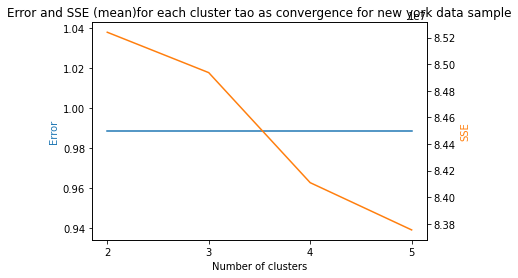

In [51]:
error_df_ny=pd.read_csv('kmeans_llyod_ny_all.csv')
print(len(error_df_ny))
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
x=error_df_ny['number_of_cluster'].value_counts().index
y1=error_df_ny.groupby(['number_of_cluster']).mean()['error']
ax1.plot(x, y1, color='tab:blue')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Error', color='tab:blue')

ax2 = ax1.twinx()
y2 = error_df_ny.groupby(['number_of_cluster']).mean()['sse']
ax2.plot(x, y2, color='tab:orange')
ax2.set_ylabel('SSE', color='tab:orange')
plt.title('Error and SSE (mean)for each cluster tao as convergence for new york data sample')
plt.xticks(range(2, 6))
plt.show()


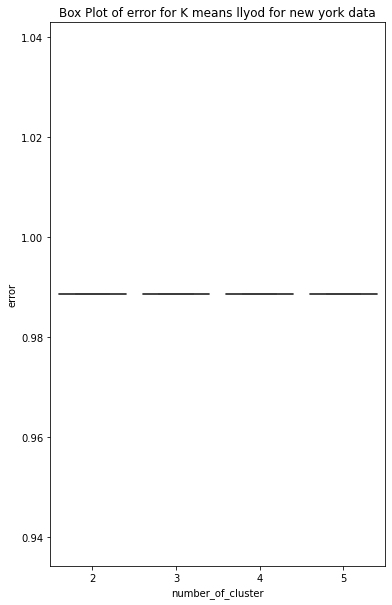

In [52]:
import seaborn as sns
plt.figure(figsize=(6, 10))
sns.boxplot(x=error_df_ny['number_of_cluster'],y=error_df_ny['error'])
plt.title('Box Plot of error for K means llyod for new york data')
plt.show()


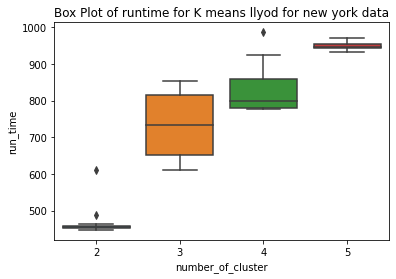

In [53]:
import seaborn as sns
sns.boxplot(x=error_df_ny['number_of_cluster'],y=error_df_ny['run_time'])
plt.title('Box Plot of runtime for K means llyod for new york data')
plt.show()
